### Exploración de Datos - ATM Route Optimizer
Este notebook explora los datos de cajeros automáticos en Bogotá para nuestra solución de optimización de rutas y predicción de demanda de efectivo.


### 1. Configuración inicial
Importamos las bibliotecas necesarias y establecemos la conexión a la base de datos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from sqlalchemy import create_engine, text
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import os
from dotenv import load_dotenv
import warnings

In [2]:
# Configuración para visualización
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener los valores del archivo .env
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

In [11]:
# Cadena de conexión para SQLAlchemy
conn_string = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/atm_optimization'
engine = create_engine(conn_string)

print(f"Conectado a: atm_optimization en {db_host}")

Conectado a: atm_optimization en localhost


In [12]:
# Verificar las tablas disponibles
query_tables = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public'
ORDER BY table_name;
"""
tables_df = pd.read_sql(query_tables, engine)
print("Tablas disponibles:")
tables_df

Tablas disponibles:


,table_name
0,atms
1,carriers
2,geography_columns
3,geometry_columns
4,restrictions
5,spatial_ref_sys
6,transactions


In [ ]:
# Verificar la estructura de la tabla atms
query_atms_structure = """
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'atms';
"""
atms_structure = pd.read_sql(query_atms_structure, engine)
print("Estructura de la tabla 'atms':")
atms_structure

# Verificar la estructura de las otras tablas
tables_to_check = ['transactions', 'restrictions', 'carriers']

for table in tables_to_check:
    query = f"""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = '{table}';
    """
    try:
        structure = pd.read_sql(query, engine)
        print(f"\nEstructura de la tabla '{table}':")
        display(structure)
    except Exception as e:
        print(f"Error al verificar la tabla '{table}': {e}")

In [ ]:
# Explorar datos de atms
query_atms = """
SELECT * FROM atms LIMIT 5;
"""
try:
    atms_sample = pd.read_sql(query_atms, engine)
    print("Muestra de datos de 'atms':")
    display(atms_sample)
except Exception as e:
    print(f"Error al explorar 'atms': {e}")

# Explorar datos de las otras tablas
for table in tables_to_check:
    query = f"""
    SELECT * FROM {table} LIMIT 5;
    """
    try:
        sample = pd.read_sql(query, engine)
        print(f"\nMuestra de datos de '{table}':")
        display(sample)
    except Exception as e:
        print(f"Error al explorar '{table}': {e}")

### Cargar datos completos para analisis

In [35]:
# Cargar datos de cajeros
try:
    # Primero intentamos cargar con extracción de coordenadas geográficas
    query_atms_with_coords = """
    SELECT id, name, 
           ST_X(location::geometry) as longitude, 
           ST_Y(location::geometry) as latitude,
           capacity, cash_type, location_type,
           min_threshold, max_capacity
    FROM atms;
    """
    atms_df = pd.read_sql(query_atms_with_coords, engine)
    print("Datos de cajeros cargados con coordenadas geográficas")
except Exception as e:
    print(f"Error al extraer coordenadas: {e}")
    print("Intentando cargar datos básicos...")
    try:
        # Si falla, cargamos los datos básicos
        query_atms_basic = """
        SELECT * FROM atms;
        """
        atms_df = pd.read_sql(query_atms_basic, engine)
        print("Datos básicos de cajeros cargados")
    except Exception as e2:
        print(f"Error al cargar datos básicos: {e2}")
        atms_df = pd.DataFrame()  # DataFrame vacío si todo falla

print(f"Total de cajeros cargados: {len(atms_df)}")
if len(atms_df) > 0:
    display(atms_df.head())

# Cargar datos de transacciones (limitados para no sobrecargar la memoria)
try:
    query_transactions = """
    SELECT * FROM transactions LIMIT 20000;
    """
    transactions_df = pd.read_sql(query_transactions, engine)
    print(f"Datos de transacciones cargados: {len(transactions_df)} registros")
    if len(transactions_df) > 0:
        display(transactions_df.head())
except Exception as e:
    print(f"Error al cargar transacciones: {e}")
    transactions_df = pd.DataFrame()

# %%
# Cargar datos de restricciones
try:
    query_restrictions = """
    SELECT * FROM restrictions;
    """
    restrictions_df = pd.read_sql(query_restrictions, engine)
    print(f"Datos de restricciones cargados: {len(restrictions_df)} registros")
    if len(restrictions_df) > 0:
        display(restrictions_df.head())
except Exception as e:
    print(f"Error al cargar restricciones: {e}")
    restrictions_df = pd.DataFrame()

# %%
# Cargar datos de transportadoras
try:
    query_carriers_with_coords = """
    SELECT id, name, 
           ST_X(base_location::geometry) as base_longitude, 
           ST_Y(base_location::geometry) as base_latitude,
           capacity, vehicles, service_area
    FROM carriers;
    """
    carriers_df = pd.read_sql(query_carriers_with_coords, engine)
    print("Datos de transportadoras cargados con coordenadas geográficas")
except Exception as e:
    print(f"Error al extraer coordenadas de transportadoras: {e}")
    try:
        query_carriers_basic = """
        SELECT * FROM carriers;
        """
        carriers_df = pd.read_sql(query_carriers_basic, engine)
        print("Datos básicos de transportadoras cargados")
    except Exception as e2:
        print(f"Error al cargar datos básicos de transportadoras: {e2}")
        carriers_df = pd.DataFrame()

print(f"Total de transportadoras cargadas: {len(carriers_df)}")
if len(carriers_df) > 0:
    display(carriers_df.head())


Datos de cajeros cargados con coordenadas geográficas
Total de cajeros cargados: 100


,id,name,longitude,latitude,capacity,cash_type,location_type,min_threshold,max_capacity
0,ATM001,Cajero Banco Oeste,-74.010092,4.793360,88842521.0,MULTIPROPÓSITO,HOSPITAL,13326378.0,106611025.0
1,ATM002,Cajero Centro Comercial Este,-74.156079,4.792098,80227437.0,MULTIPROPÓSITO,TRANSPORT,12034115.0,96272924.0
2,ATM003,Cajero Centro Comercial Oeste,-74.123304,4.628780,63663448.0,DISPENSADOR,TRANSPORT,9549517.0,76396137.0
3,ATM004,Cajero Centro Comercial Este,-74.047094,4.760802,71409483.0,MULTIPROPÓSITO,MALL,10711422.0,85691379.0
4,ATM005,Cajero Centro Comercial Sur,-74.125042,4.542538,69156015.0,MULTIPROPÓSITO,OFFICE,10373402.0,82987218.0


Datos de transacciones cargados: 20000 registros


,id,atm_id,transaction_date,transaction_time,amount,transaction_type,day_of_week
0,1,ATM006,2023-09-24,14:39:10,842691.0,RETIRO,7
1,2,ATM037,2023-11-21,04:30:15,829280.0,RETIRO,2
2,3,ATM085,2023-09-07,16:01:44,2056342.0,DEPÓSITO,4
3,4,ATM036,2023-11-19,02:24:49,4459390.0,DEPÓSITO,7
4,5,ATM073,2023-10-29,16:45:52,2670440.0,DEPÓSITO,7


Datos de restricciones cargados: 700 registros


,id,atm_id,day_of_week,open_time,close_time,restock_allowed,notes
0,1,ATM001,1,00:00:00,23:59:59,True,Acceso 24h
1,2,ATM001,2,00:00:00,23:59:59,True,Acceso 24h
2,3,ATM001,3,00:00:00,23:59:59,True,Acceso 24h
3,4,ATM001,4,00:00:00,23:59:59,True,Acceso 24h
4,5,ATM001,5,00:00:00,23:59:59,True,Acceso 24h


Datos de transportadoras cargados con coordenadas geográficas
Total de transportadoras cargadas: 5


,id,name,base_longitude,base_latitude,capacity,vehicles,service_area
0,TDV002,TransValues Ltda,-74.1347,4.6212,700000000.0,15,SUR
1,TDV003,Protección Cash SAS,-74.0723,4.7121,600000000.0,12,CENTRO
2,TDV004,Segurtrans S.A.,-74.0501,4.6854,550000000.0,8,OESTE
3,TDV005,Vigilancia Financiera LTDA,-74.1005,4.7350,650000000.0,14,ESTE
4,TDV001,Transportadora Seguridad SA,-74.0628,4.6486,500000000.0,10,NORTE


#### Análisis de cajeros

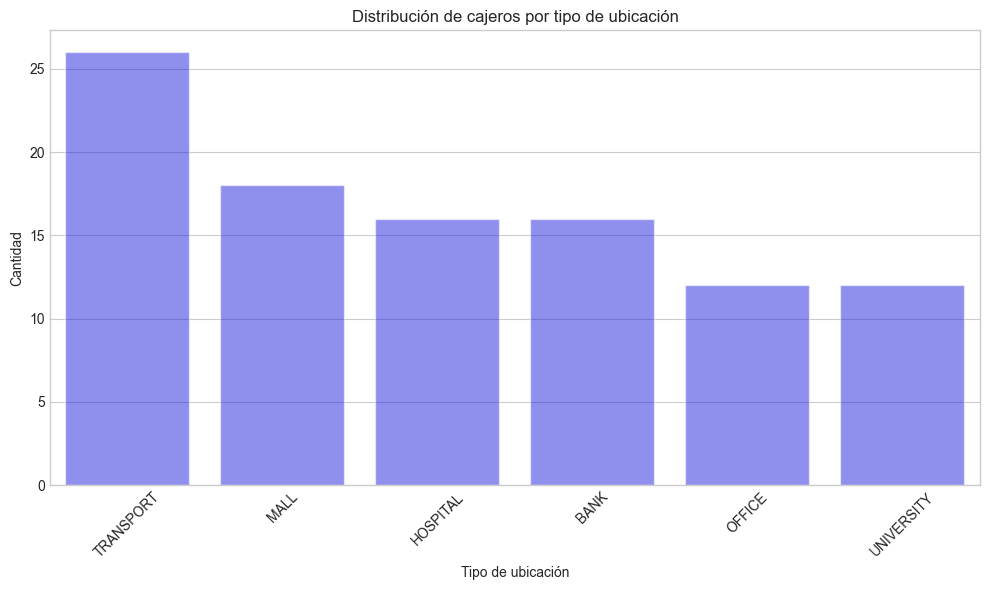

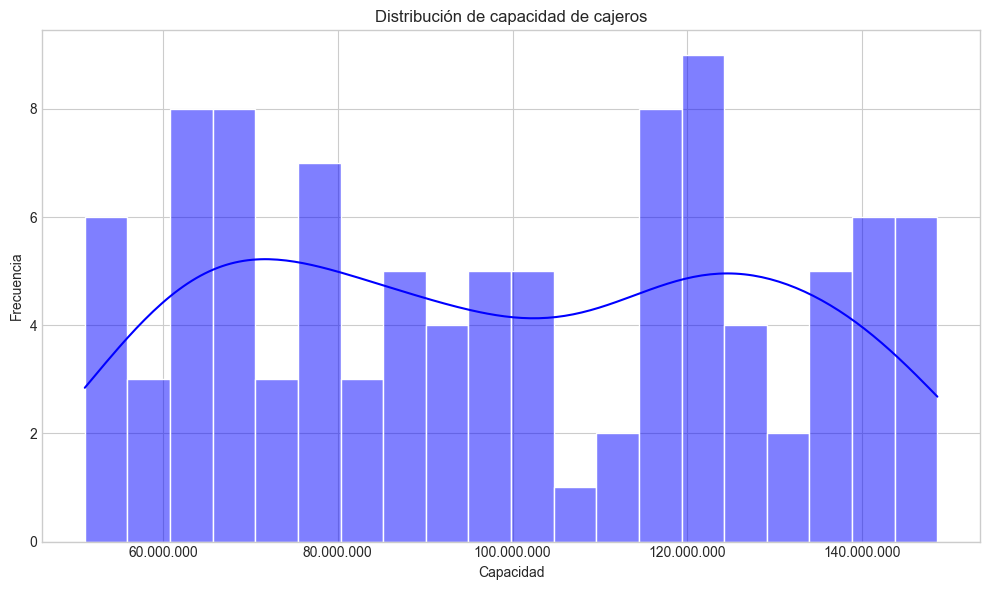

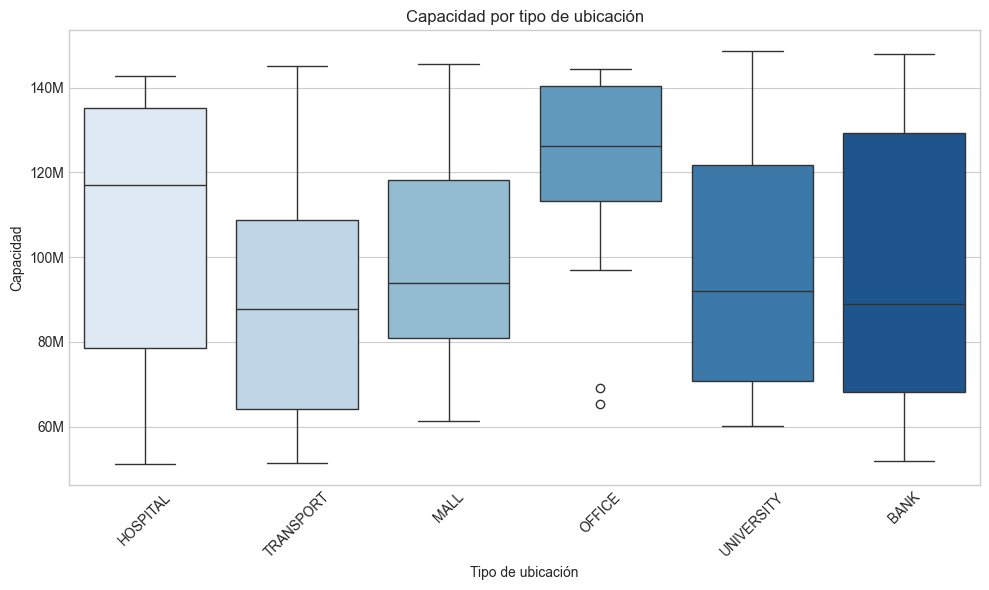

In [ ]:
# Verificar si tenemos datos de cajeros para analizar
if len(atms_df) > 0:
    # Estadísticas básicas
    # print("Estadísticas básicas de cajeros:")
    # display(atms_df.describe(include='all'))
    
    # Distribución por tipo
    if 'location_type' in atms_df.columns:
        plt.figure(figsize=(10, 6))
        location_counts = atms_df['location_type'].value_counts()
        sns.barplot(x=location_counts.index, y=location_counts.values, color='blue', alpha=0.5)
        plt.title('Distribución de cajeros por tipo de ubicación')
        plt.xlabel('Tipo de ubicación')
        plt.ylabel('Cantidad')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Distribución de capacidad 
    if 'capacity' in atms_df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(atms_df['capacity'], bins=20, kde=True, color='blue', alpha=0.5)
        plt.title('Distribución de capacidad de cajeros')
        plt.xlabel('Capacidad')
        plt.ylabel('Frecuencia')
        plt.ticklabel_format(style='plain', axis='x')
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:,.0f}'.replace(',','.')))
        plt.tight_layout()
        plt.show()
        
        # Capacidad por tipo 
        if 'location_type' in atms_df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='location_type', y='capacity', data=atms_df, palette="Blues")
            plt.title('Capacidad por tipo de ubicación')
            plt.xlabel('Tipo de ubicación')
            plt.ylabel('Capacidad')
            plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}M'))
            plt.xticks(rotation=45)
            plt.tight_layout() 
            plt.show()
else:
    print("No hay datos de cajeros para analizar")

### Visualización geoespacial de cajeros y transportadoras

#### Código de configuración del mapa

In [33]:
# Verificar si tenemos coordenadas para visualización
has_atm_coords = all(col in atms_df.columns for col in ['latitude', 'longitude']) and len(atms_df) > 0
has_carrier_coords = all(col in carriers_df.columns for col in ['base_latitude', 'base_longitude']) and len(carriers_df) > 0

if has_atm_coords or has_carrier_coords:
    # Crear mapa centrado de Bogotá
    if has_atm_coords:
        map_center = [atms_df['latitude'].mean(), atms_df['longitude'].mean()]
    elif has_carrier_coords:
        map_center = [carriers_df['base_latitude'].mean(), carriers_df['base_longitude'].mean()]
    else:
        map_center = [4.6486, -74.0628]  # Centro de Bogotá por defecto
    
    m = folium.Map(location=map_center, zoom_start=12)
    
    # Añadir cajeros
    if has_atm_coords:
        marker_cluster = MarkerCluster().add_to(m)
        
        for idx, row in atms_df.iterrows():
            tooltip = f"{row['name']}"
            
            # Popup de información
            popup_content = f"<b>{row['name']}</b><br>"
            
            if 'location_type' in atms_df.columns:
                popup_content += f"Tipo: {row['location_type']}<br>"
            
            if 'capacity' in atms_df.columns:
                popup_content += f"Capacidad: {row['capacity']:,.0f} COP<br>"
            
            if 'cash_type' in atms_df.columns:
                popup_content += f"Tipo de cajero: {row['cash_type']}"
            
            # Color según la ubicación
            icon_color = 'blue'  
            
            if 'location_type' in atms_df.columns:
                if row['location_type'] == 'MALL':
                    icon_color = 'red'
                elif row['location_type'] == 'TRANSPORT':
                    icon_color = 'blue'
                elif row['location_type'] == 'UNIVERSITY':
                    icon_color = 'green'
                else:
                    icon_color = 'gray'
            
            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=popup_content,
                tooltip=tooltip,
                icon=folium.Icon(color=icon_color)
            ).add_to(marker_cluster)
    
    # Transportadoras
    if has_carrier_coords:
        for idx, row in carriers_df.iterrows():
            tooltip = f"Transportadora: {row['name']}"
            
            popup_content = f"<b>{row['name']}</b><br>"
            
            if 'capacity' in carriers_df.columns:
                popup_content += f"Capacidad: {row['capacity']:,.0f} COP<br>"
            
            if 'vehicles' in carriers_df.columns:
                popup_content += f"Vehículos: {row['vehicles']}<br>"
            
            if 'service_area' in carriers_df.columns:
                popup_content += f"Área de servicio: {row['service_area']}"
            
            folium.Marker(
                location=[row['base_latitude'], row['base_longitude']],
                popup=popup_content,
                tooltip=tooltip,
                icon=folium.Icon(color='black', icon='truck', prefix='fa')
            ).add_to(m)
    
else:
    print("No hay coordenadas disponibles para visualización geoespacial")

#### Mostrar el mapa

In [61]:
## Mostrar mapa
display(m)

### Análisis de transacciones

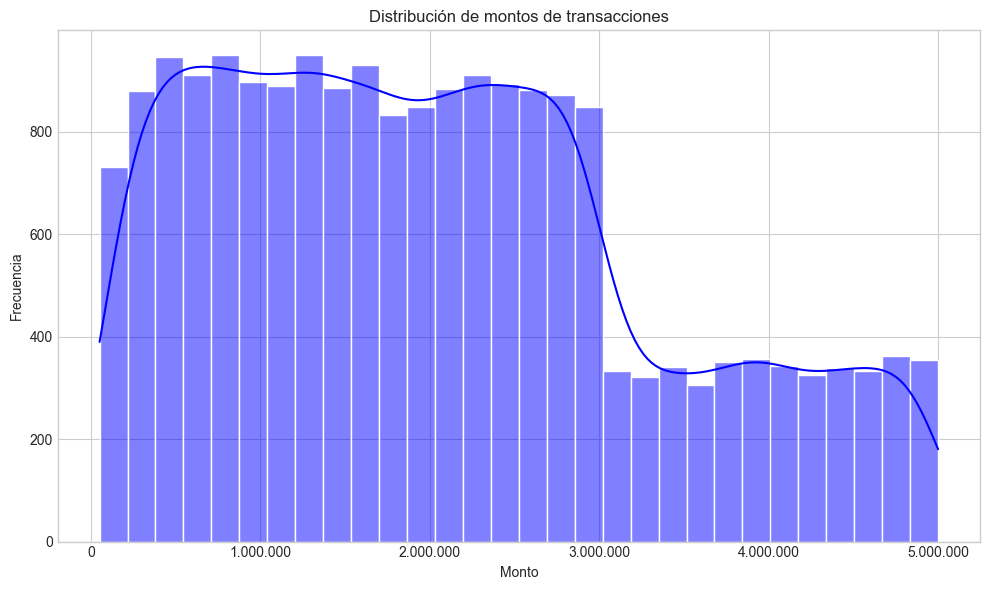

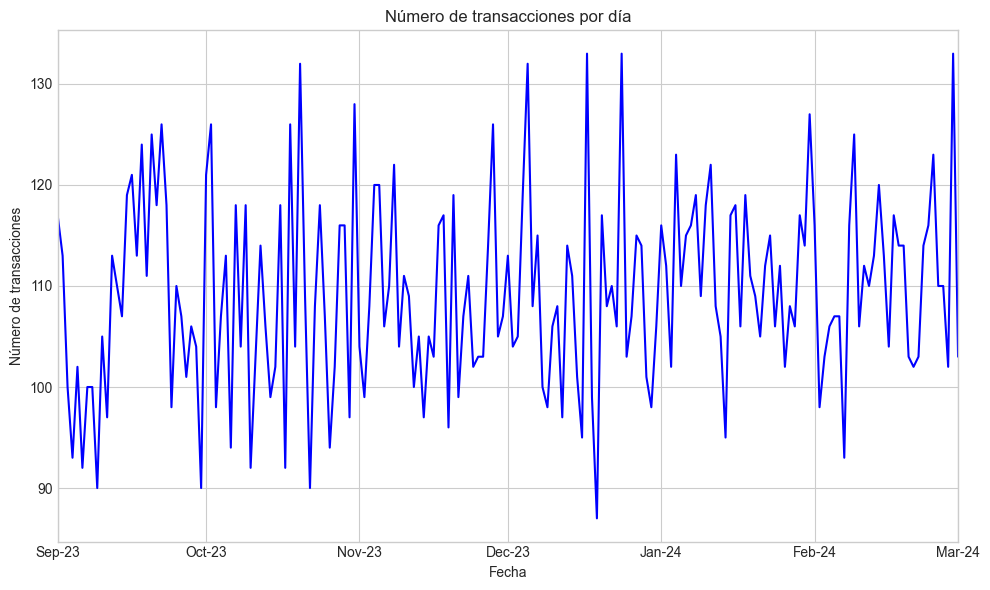

In [45]:
# Convertir la fecha a datetime si es necesario
if 'transaction_date' in transactions_df.columns:
    transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Gráfica de distribución de montos de transacciones
plt.figure(figsize=(10, 6))
sns.histplot(transactions_df['amount'], bins=30, kde=True, color='blue', alpha=0.5)
plt.title('Distribución de montos de transacciones')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.ticklabel_format(style='plain', axis='x')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:,.0f}'.replace(',','.')))
plt.tight_layout()
plt.show()

# Gráfica de número de transacciones por día
if 'transaction_date' in transactions_df.columns:
    daily_counts = transactions_df.groupby(transactions_df['transaction_date']).size()
    
    plt.figure(figsize=(10, 6))
    daily_counts.plot(color='blue')
    plt.title('Número de transacciones por día')
    plt.xlabel('Fecha')
    plt.ylabel('Número de transacciones')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    # plt.gca().xaxis.set_major_formatter(mdates.MonthLocator())
    plt.tight_layout()
    plt.show()

### Análisis de restricciones

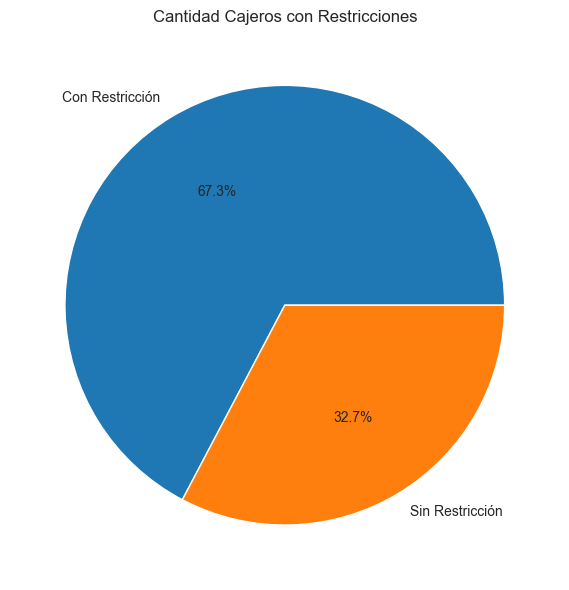

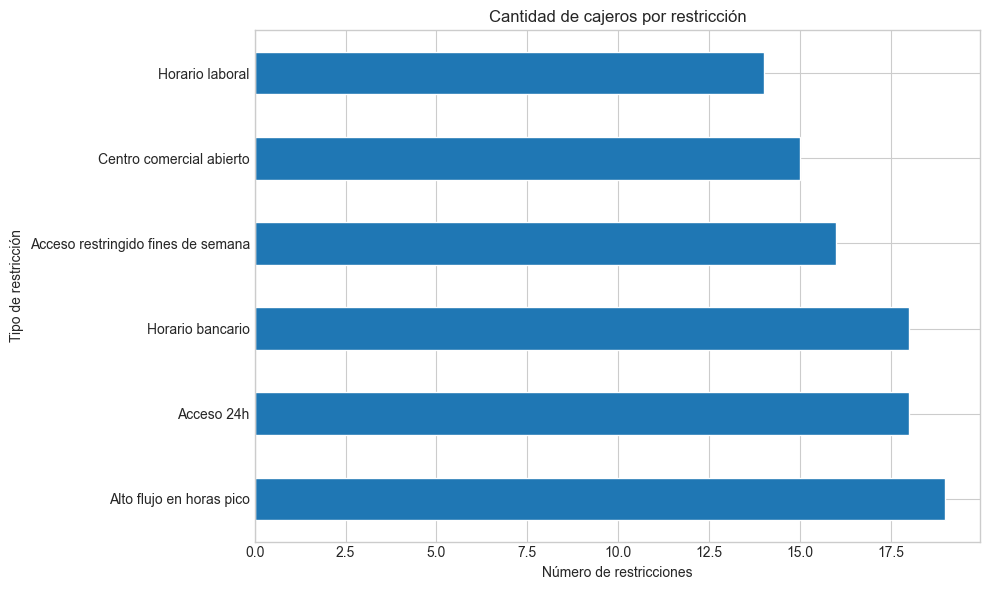

In [60]:
# Verificar si tenemos restricciones para analizar
if len(restrictions_df) > 0:
        
    # Restricciones permitidas vs no permitidas
    if 'restock_allowed' in restrictions_df.columns:
        allowed_counts = restrictions_df['restock_allowed'].replace({True: 'Con Restricción', False: 'Sin Restricción'}).value_counts()
        
        plt.figure(figsize=(8, 6))
        allowed_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Cantidad Cajeros con Restricciones')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    
    # Restricciones por cajero
    if 'atm_id' in restrictions_df.columns:
        unique_restrictions = restrictions_df[['atm_id', 'notes']].drop_duplicates()
        atm_restriction_counts = unique_restrictions.groupby('notes').size().sort_values(ascending=False)
        
        plt.figure(figsize=(10, 6))
        atm_restriction_counts.plot(kind='barh')
        plt.title('Cantidad de cajeros por restricción')
        plt.xlabel('Número de restricciones')
        plt.ylabel('Tipo de restricción')
        plt.tight_layout()
        plt.show()
else:
    print("No hay datos de restricciones para analizar")